# Permeability Simulation Using PoreSpy and OpenPNM
This simulation is based on the original notebook (https://github.com/PMEAL/OpenPNM/blob/master/examples)

### Importing Packages

In [1]:
import time
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
import tifffile
np.set_printoptions(precision=4)
np.random.seed(10)
%matplotlib inline

D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\algorithms\_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover
D:\Software\Anaconda\envs\puma_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


### Load Data

In [2]:
resolution = 60e-6

#reading a binary image from a tif file
img = tifffile.imread('data.tif')

In [3]:
print('Prosity = ',ps.metrics.porosity(img))
print('image shape = ',img.shape)
print('image data type = ',img.dtype)

Prosity =  0.5327764375
image shape =  (400, 400, 400)
image data type =  uint8


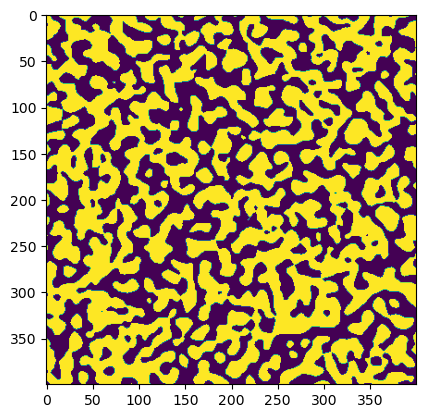

In [14]:
plt.imshow(img[0])

### Create Pore Network via PoreSpy 

In [1]:
img = img==0
snow = ps.networks.snow2(img, voxel_size= resolution)

NameError: name 'img' is not defined

### Import network in OpenPNM

The output from the SNOW algorithm above is a plain python dictionary containing all the extracted pore-scale data, but it is NOT yet an OpenPNM network. We need to create an empty network in OpenPNM, then populate it with the data from SNOW

In [5]:
pn = op.io.network_from_porespy(snow.network)

In [6]:
print (pn)


══════════════════════════════════════════════════════════════════════════════
net : <openpnm.network.Network at 0x1f7101b7f90>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  2  throat.conns                                                42109 / 42109
  3  pore.coords                                                 16468 / 16468
  4  pore.region_label                                           16468 / 16468
  5  pore.phase                                                  16468 / 16468
  6  throat.phases                                               42109 / 42109
  7  pore.region_volume                                          16468 / 16468
  8  pore.equivalent_diameter                                    16468 / 16468
  9  pore.local_peak                                             16468 / 16468
 1

In [7]:
# Something related to the recent update of the library (ignore it)
pn['pore.diameter'] = pn['pore.equivalent_diameter']
pn['throat.diameter'] = pn['throat.inscribed_diameter']
pn['throat.spacing'] = pn['throat.total_length']

The user also needs to decide which ‘shape’ to assume for the pores and throats, which impacts how the transport conductance values are computed. Here we use the pyramids_and_cuboid models:

In [8]:
pn.add_model(propname='throat.hydraulic_size_factors',
             model=op.models.geometry.hydraulic_size_factors.pyramids_and_cuboids)
pn.add_model(propname='throat.diffusive_size_factors',
             model=op.models.geometry.diffusive_size_factors.pyramids_and_cuboids)
pn.regenerate_models()

### Check network health

Remove isolated pores or cluster of pores from the network by checking it network health. Make sure ALL keys in network health functions have no value. 

In [9]:
h = op.utils.check_network_health(pn)
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      [338, 2498, 2936, 2947, 3084, 3789, 5419, 5893, 6095, 6824, 7339, 7395, 8442, 8532, 9496, 10139, 11308, 12183, 12892, 13045]
disconnected_pores                  [338, 2498, 2936, 2947, 3084, 3240, 3789, 5419, 5893, 6095, 6824, 7339, 7395, 8442, 8532, 9496, 10139, 11308, 12183, 12892, 13045, 14405]
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [10]:
#Trimming disconnected pores
op.topotools.trim(network=pn, pores=h['disconnected_pores'])
h = op.utils.check_network_health(pn)
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Key                                 Value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
headless_throats                    []
looped_throats                      []
isolated_pores                      []
disconnected_pores                  []
duplicate_throats                   []
bidirectional_throats               []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


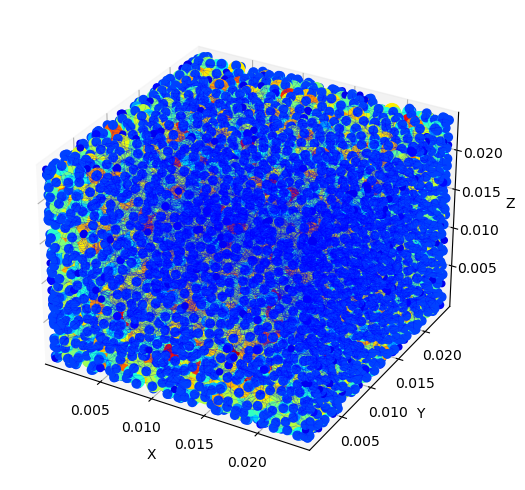

In [11]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(img[0].T, cmap=plt.cm.bone);
op.visualization.plot_coordinates(ax=fig,
                                  network=pn,
                                  size_by=pn["pore.inscribed_diameter"],
                                  color_by=pn["pore.inscribed_diameter"],
                                  markersize=200)
op.visualization.plot_connections(network=pn, ax=fig,linewidth=0.1)
ax.axis("off");

In [12]:
def calculate_permeability(pn, p1,p2):
    # p1 , p2 should be from pn labels, use print(pn) to check labels
    phase = op.phase.Phase(network=pn)
    phase['pore.viscosity']=1.0
    phase.add_model_collection(op.models.collections.physics.basic)
    phase.regenerate_models()
    
    inlet = pn.pores(p1)
    outlet = pn.pores(p2)
    flow = op.algorithms.StokesFlow(network=pn, phase=phase)
    flow.set_value_BC(pores=inlet, values=1)
    flow.set_value_BC(pores=outlet, values=0)
    flow.run()
    phase.update(flow.soln)

    #plotting
    ax = op.visualization.plot_connections(pn)
    ax = op.visualization.plot_coordinates(pn, ax=ax, color_by=phase['pore.pressure'])

    Q = flow.rate(pores=inlet, mode='group')[0]
    A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
    L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
    # K = Q * L * mu / (A * Delta_P) # mu and Delta_P were assumed to be 1.
    k = Q * L / A
    print ('k original= ', k)
    print(f'The value of K is: {k/0.98e-12*1000:.2f} mD')
    op.io.project_to_vtk(pn.project, filename='Paraview_net')
    return k

[15:48:57] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=490637;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=407288;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=658042;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=513609;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

[15:48:58] WARNING  Attempting to estimate inlet area...will be low                              ]8;id=205427;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=203898;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py#1033\1033]8;;\

           ERROR    Inlet and outlet faces are different area                                    ]8;id=726033;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=30578;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py#1051\1051]8;;\

           WARNING  Attempting to estimate domain length...could be low if boundary pores were   ]8;id=33469;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=841443;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py#1077\1077]8;;\
                    not added                                                                                      

           ERROR    A unique value of length could not be found                                  ]8;id=615178;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py\_topotools.py]8;;\:]8;id=373155;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\topotools\_topotools.py#1087\1087]8;;\

k original=  6.903880805554851e-09
The value of K is: 7044776.33 mD


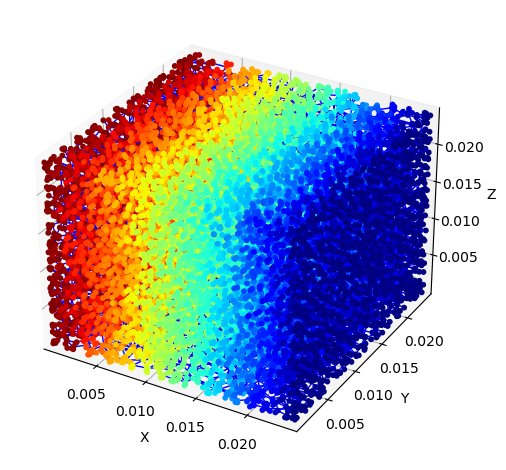

In [13]:

kx = calculate_permeability(pn,'xmin','xmax')
ky = calculate_permeability(pn,'ymin','ymax')
kz = calculate_permeability(pn,'zmin','zmax')
#print (round(kx,1),round(ky,1),round(kz,1))


### In case of 2D images the network is as below

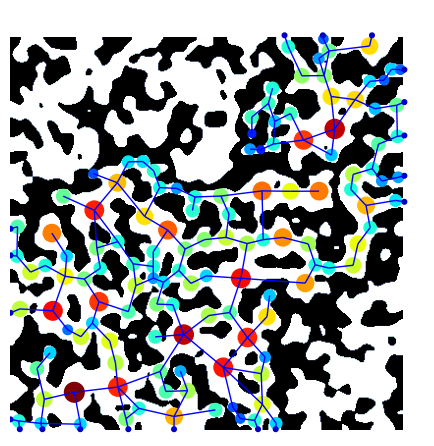

In [74]:
fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(im.T, cmap=plt.cm.bone);
op.visualization.plot_coordinates(ax=fig,
                                  network=pn,
                                  size_by=pn["pore.inscribed_diameter"],
                                  color_by=pn["pore.inscribed_diameter"],
                                  markersize=200)
op.visualization.plot_connections(network=pn, ax=fig)
ax.axis("off");

In [1]:
import microstructure_parameters as mp
import tifffile

D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\algorithms\_invasion_percolation.py:358: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _find_trapped_pores(inv_seq, indices, indptr, outlets):  # pragma: no cover
D:\Software\Anaconda\envs\puma_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:

resolution = 60e-6
#reading a binary image from a tif file
img = tifffile.imread('data.tif')

In [3]:


k = mp.calculate_permeability(img, resolution)
print ('Permeability = ',k)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/16468 [00:00<?, ?it/s]

[11:19:52] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=872382;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=565924;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

           WARNING  throat.diffusive_conductance was not run since the following property is         ]8;id=147360;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=55098;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    missing: 'throat.diffusivity'                                                                  

Permeability =  (6.752548400493012e-09, 5.021976934755347e-09, 4.8727866145054655e-09)


In [4]:
tau = mp.calculate_tortuosity(img,resolution)
print ('tortuosity = ',tau)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/16468 [00:00<?, ?it/s]

[11:22:23] WARNING  throat.entry_pressure was not run since the following property is missing:       ]8;id=486099;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py\_models.py]8;;\:]8;id=995569;file://D:\Software\Anaconda\envs\puma_env\lib\site-packages\openpnm\core\_models.py#480\480]8;;\
                    'throat.surface_tension'                                                                       

tortuosity =  (3.604345380287803, 2.3342009383002864, 1.914411954792411)
